# Visualizing attention-only transformer

This notebook reproduces the results of the blog post [???]. 

In [1]:
import torch as t
from utils import power_unif_law, generate_data
import train
import interp
from models import AoT

## Defining Transformers 

We strat by initializing the Transformer. The proposed Transformer are designed to match the ones from the blog post.\
Then we train the Transformer on an associative memory task: the prior distribution is $\pi(t_1,t_2) = \frac{1}{dict\_ size^2}$ 
while the posterior is $\pi(t_3|t_1, t_2)\in\{0,1\}$.
* T1 and T3 should have 0.99 accuracy, they are able to remember every associations,
* T2 however cannot remember every association since it has only one attention head,

In [2]:
transformer_id = "T1"

# Tunable parmaters
if transformer_id == "T1":
    dict_size = 5
    nb_head = 1
    nb_att_mod = 3
elif transformer_id == "T2":
    dict_size = 3
    nb_head = 1
    nb_att_mod = 1
elif transformer_id == "T3":
    dict_size = 5
    nb_head = 3
    nb_att_mod = 3

# Common parameters
context_window = 3
nb_layers = 1
emb_dim = 3

model = AoT(emb_dim, dict_size, nb_layers, nb_att_mod, nb_head, context_window, pi=[])

In [3]:
t.manual_seed(0)

# Training parameters
batch_size=2**9
num_batch=4000
lr=1e-3

#Distribution parameters 
pi = power_unif_law([1, 1, 1], [dict_size, dict_size, 1], dict_size)
model.pi = pi

#Training set
Data = generate_data(batch_size, num_batch, pi, context_window)

Dict = train.train(model, Data, lr)
print("KL-divergence: ", sum(Dict['Loss'][-100:-1])/100)
print("Accuracy: ", sum(Dict['Acc'][-100:-1])/100)

del Data

100%|██████████| 4000/4000 [00:21<00:00, 190.30it/s]

KL-divergence:  0.004828088274225592
Accuracy:  0.99


## Visualizing the Transformer on a Torus

There are 5 different classes to be predicted, each one represented by a color.\
Thus, the Transformer can be understood as a map from the torus to the predicted class: $T:\mathbb{S}^1\times\mathbb{S}^1\rightarrow[dict\_ size]$.\
We plot below the probability of the most likely class, the color of that class is the maximum, where intensity encodes probability.

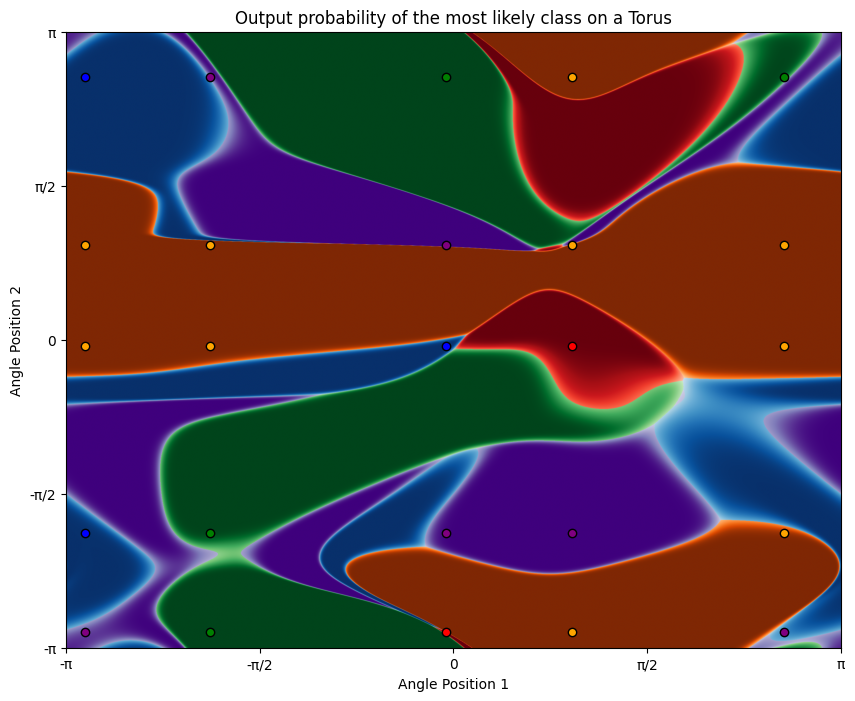

In [4]:
interp.plot_classes_full_torus(model)

## Visualizing the unembedding

Now that we have a trained Transformer, we can start by visualizing the unembedding $W_U$. Since the task is to predict a single class for each input, $W_U$ can be viewed as a clustering of $\mathbb{R}^3$. The clusters corresponds to weigthed Voronoi cells $V_{cells}(c) = \{x: w_U(c)\cdot x \geq w_U(c')\cdot x\}$. Note that the norm of a vector doesn't change its cell, thus we can plot the clustering on the sphere.\
On the graph, we represent each cluster by a color, as well as black dots for the images of token pairs by the Attention layer, and white dots for the normalized columns of $W_U$. 

In [5]:
interp.plot_unemb(model)

## Visualizing an attention head

The attention pattern formula is given by $a(e_1, e_2) = \frac{1}{1+e^{raw(e_1, e_2)}}$ and $raw(e_1, e_2) = (e_2+pos_2)^TW_{QK}(e_2+pos_2 - e_1-pos_1)$. $a$ is the probability of position 2 attending to position 1.

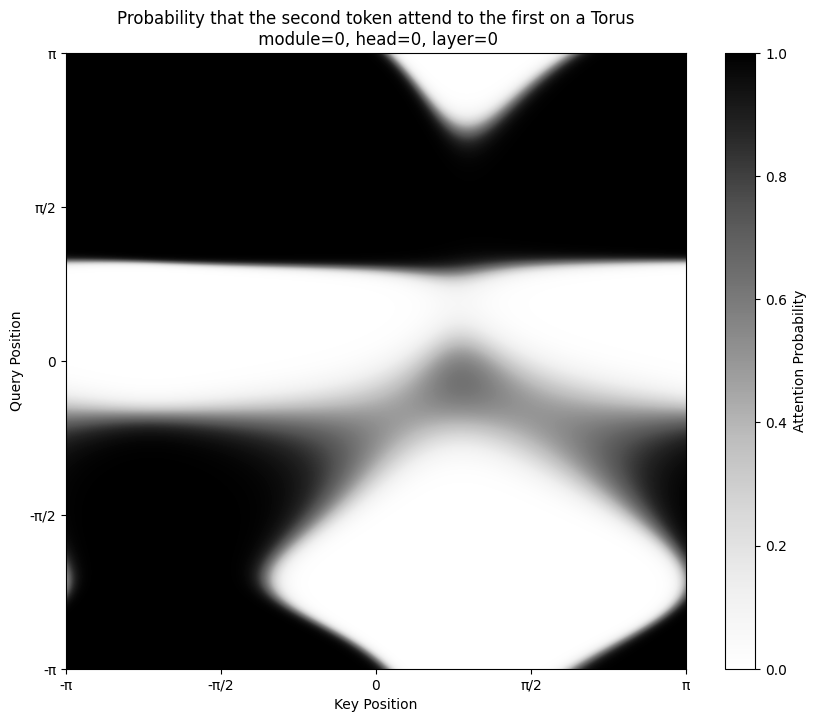

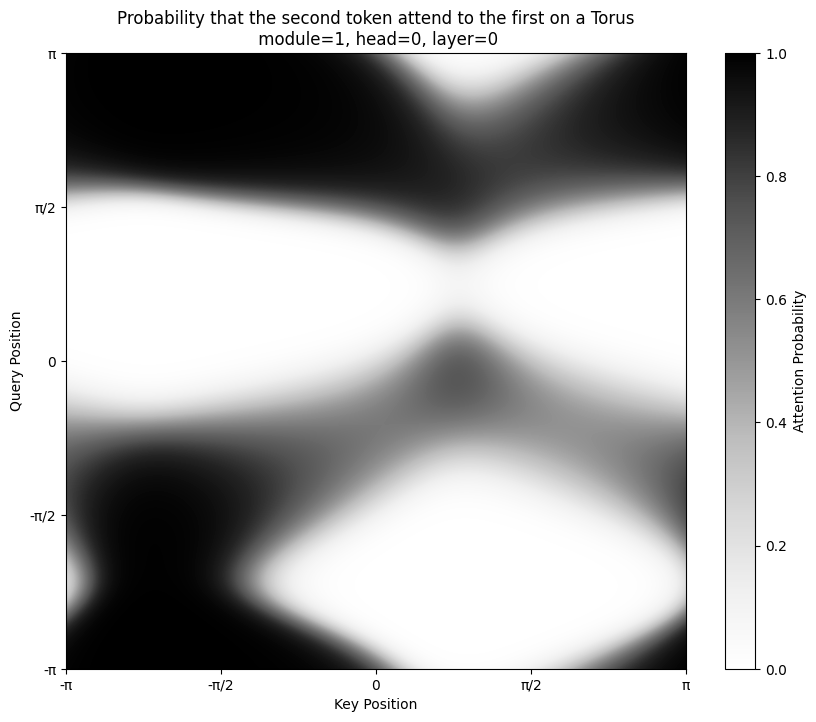

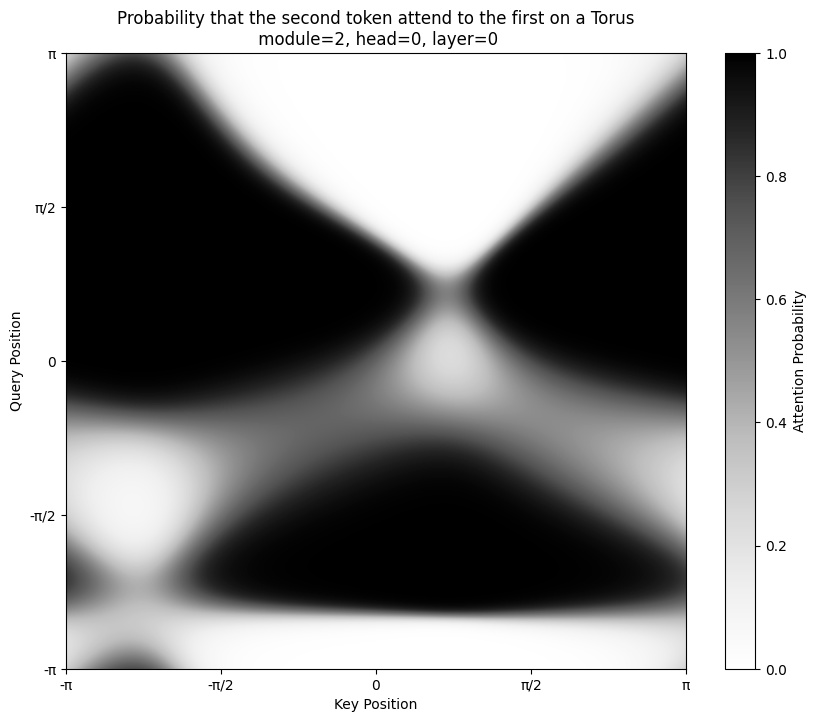

In [6]:
hardmax = False
for module in range(nb_att_mod):
    for head in range(nb_head):
        interp.plot_attention_torus(model, module, head, hardmax=hardmax)

Below is the code to visualize the embedding space outputed by a specific layer & module & head. \
As explained in the blogpost, one can seperate the output between a positional term $a_1(e_1,e_2)*pos_1 + a_2(e_1,e_2)*pos_1$ and a token term $a_1(e_1,e_2)*e_1 + a_2(e_1,e_2)*e_1$.\
The 'mode' parameter controls computation is done. One can also choose to visualize the output embedding space before or after the $W_{OV}$ product.\
\
*About scaling*: to visualize the images in RGB we rescale them to $[0,1]$. Basically, the unscaled RGBs given to the function 'plot_RGB_torus' will be rescaled using the same parameter, making the plots summable. Thus, the image given by the functions 'pos' and 'word' can be added to give exactly th result of 'both'. Note that each dimension has its own rescaling to make the color more vivid.

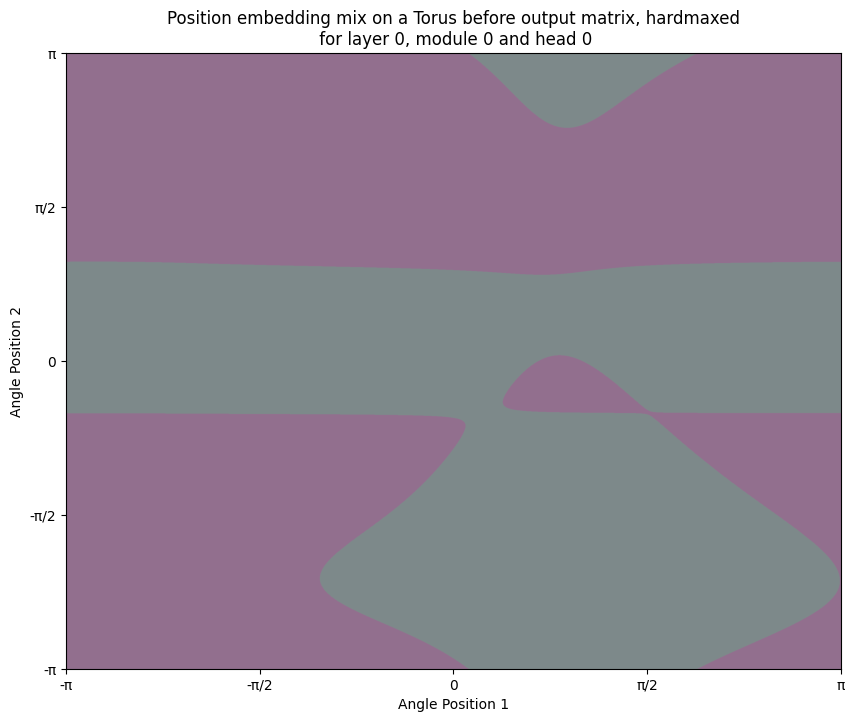

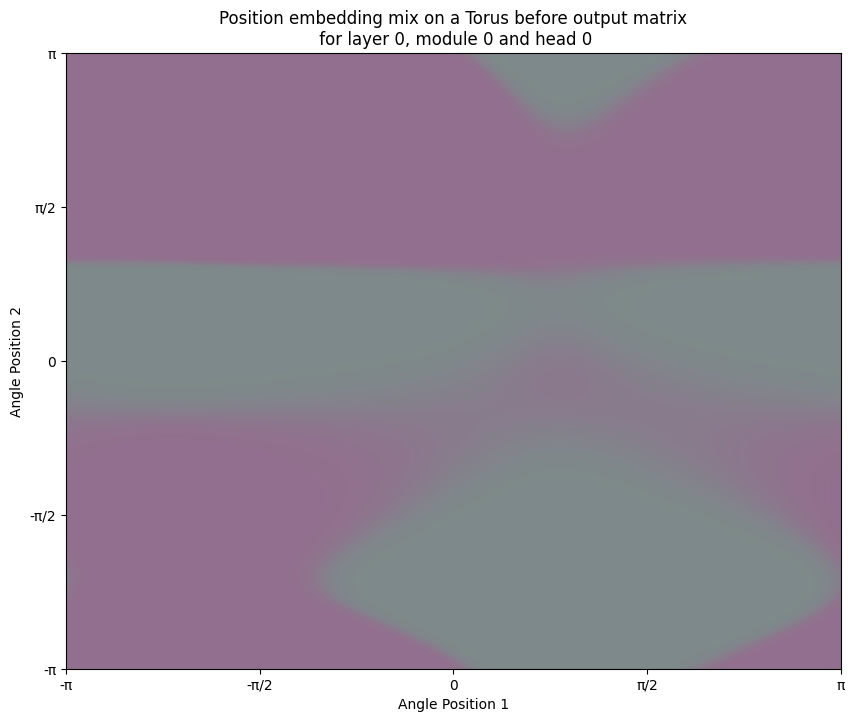

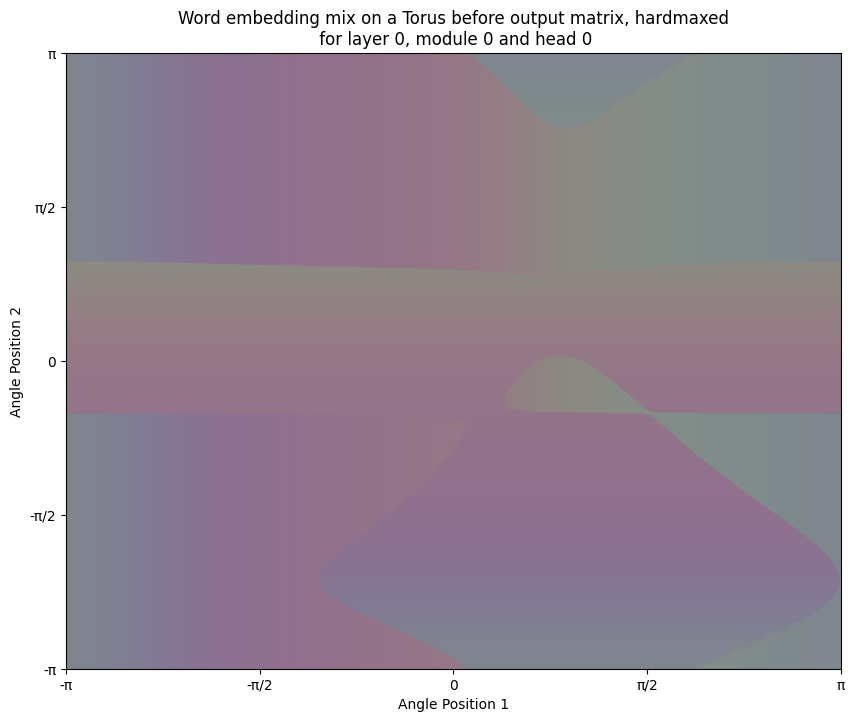

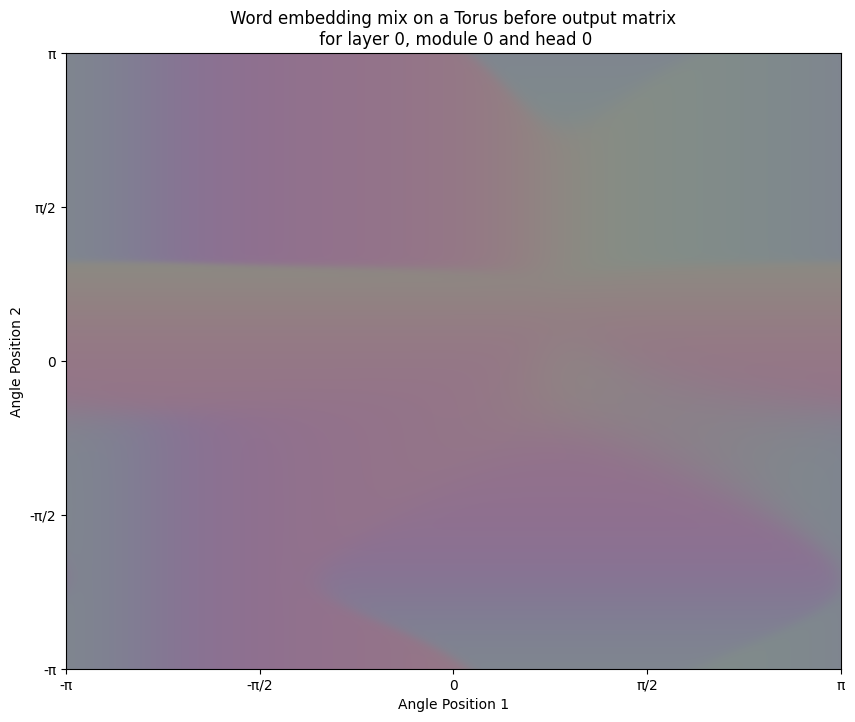

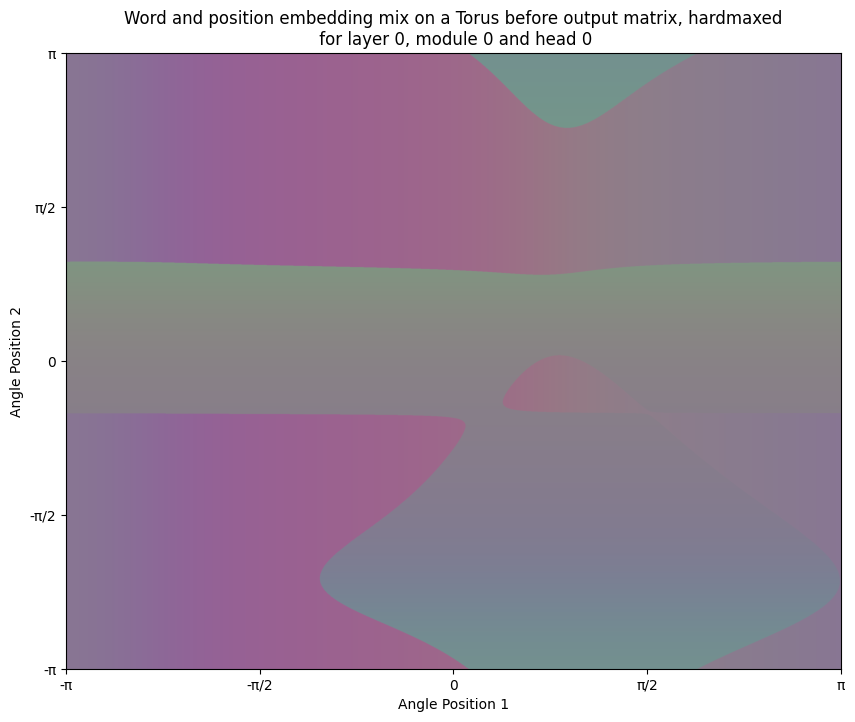

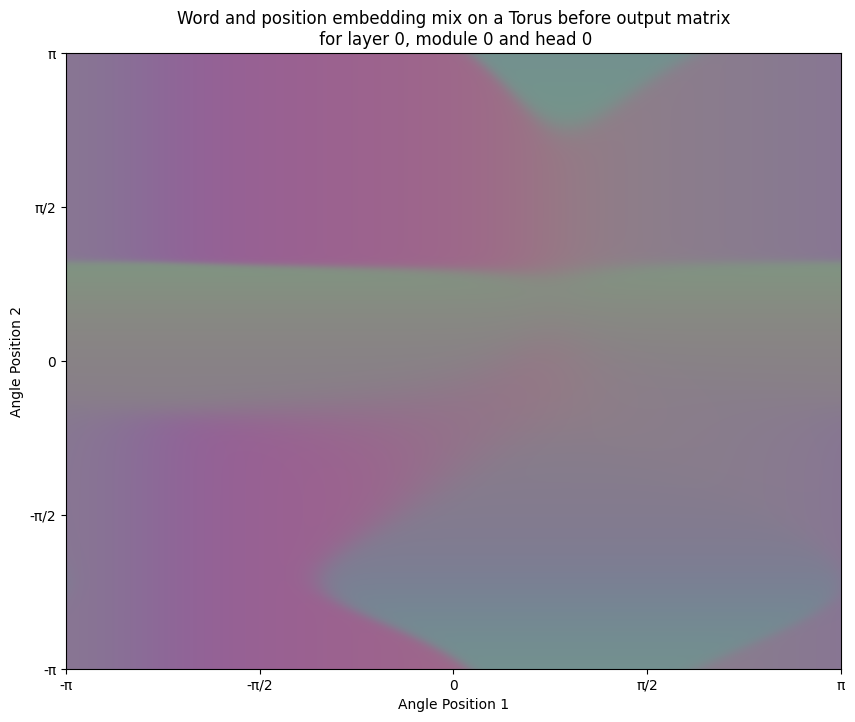

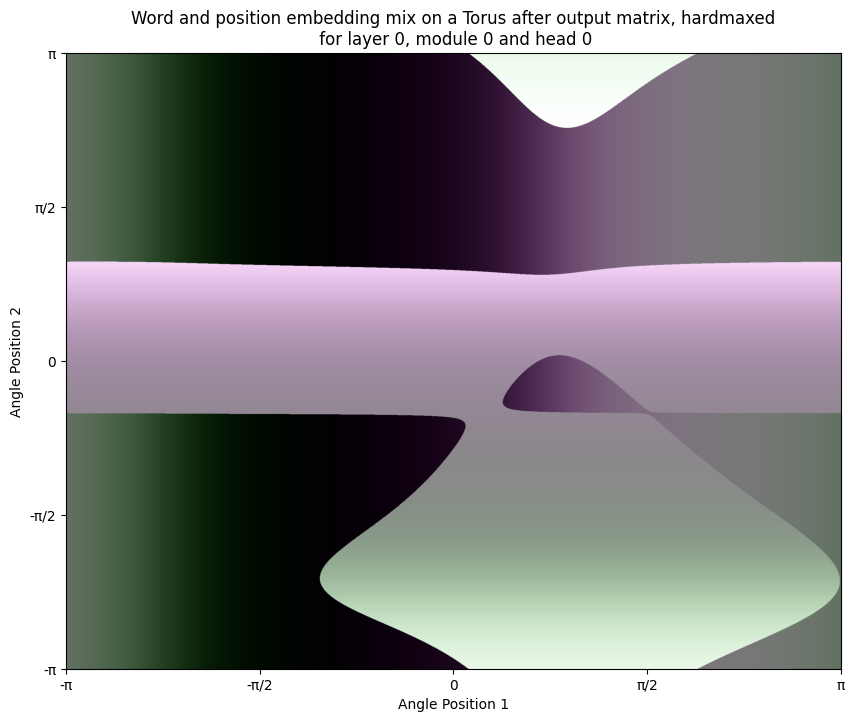

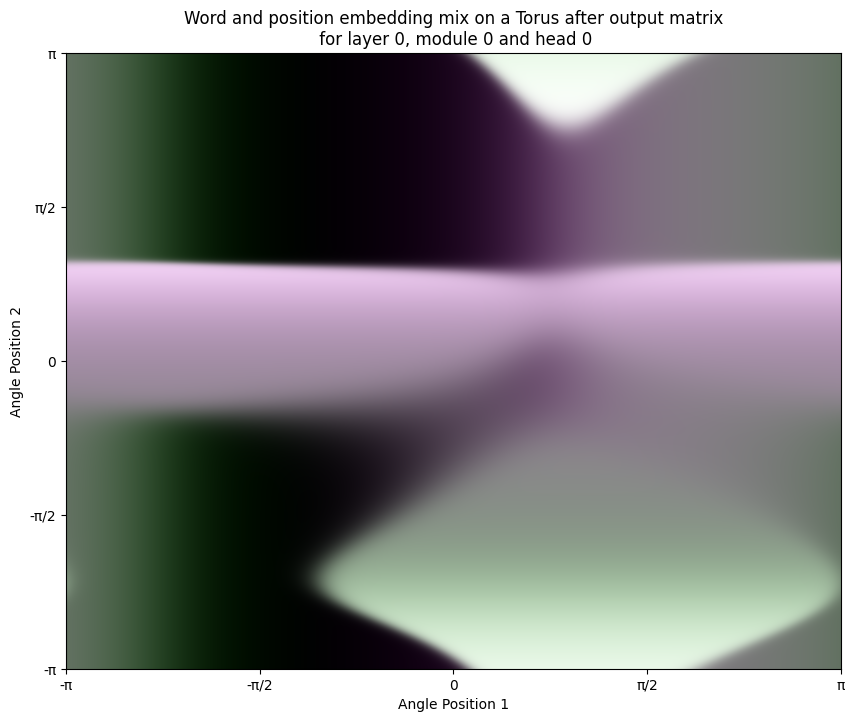

In [7]:
module = 0
head = 0
layer = 0

unscaled_RGBs = []

unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="pos", hardmax=True, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="pos", hardmax=False, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="word", hardmax=True, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="word", hardmax=False, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=True, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=False, use_OV=False))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=True, use_OV=True))
unscaled_RGBs.append(interp.token_mixing_torus(model, module, head, layer, mode="both", hardmax=False, use_OV=True))

# Plot all the graphs stored into data_list
interp.plot_RGB_torus(unscaled_RGBs)

Using the same function, we can also print the output of each head as well as how they combine.\
Thanks to the additivity of the plots, we can see that some properties of the sum of the heads are just properties of the heads.\
Especially, the edges, at which we have a change of colors, are edges of one of the plots, just superposed. \
So the edges of the attention pattern will determine the edges of the final figure.

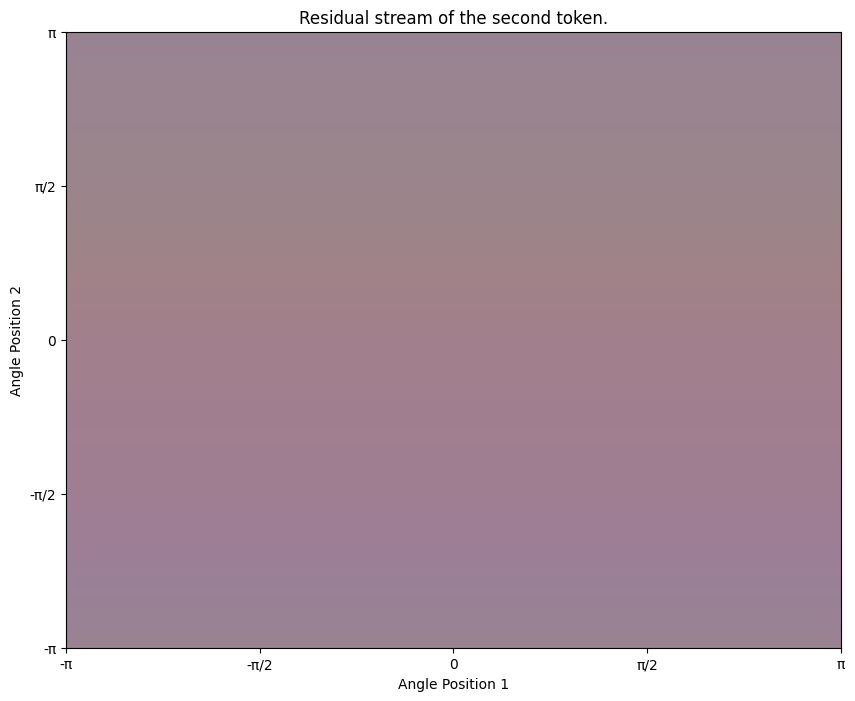

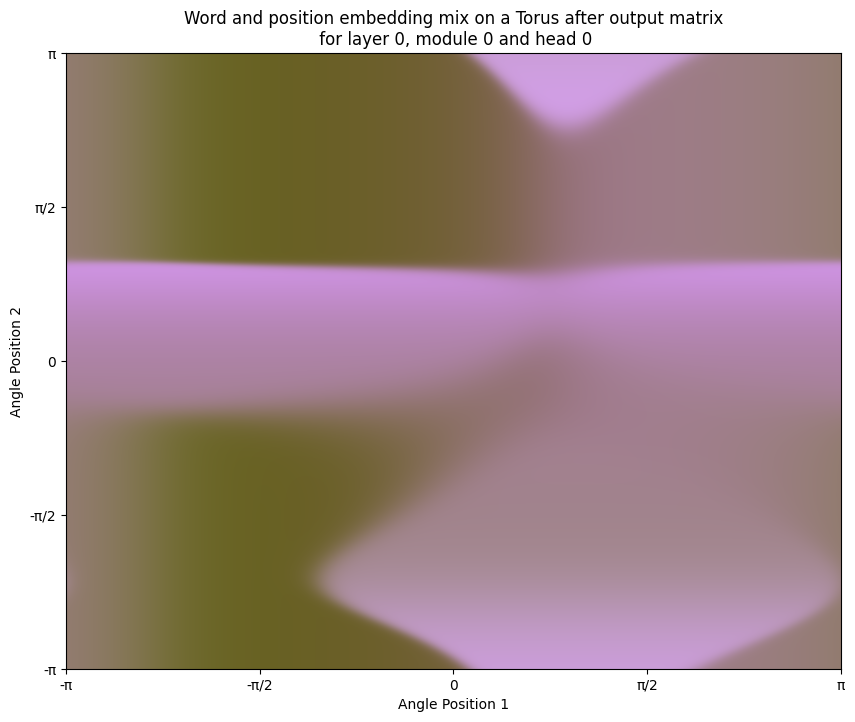

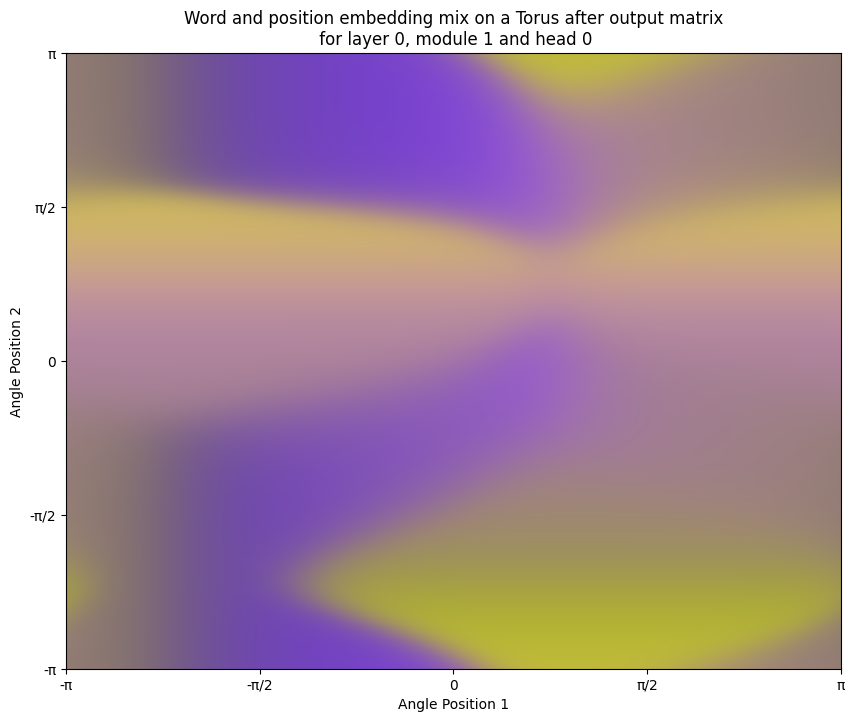

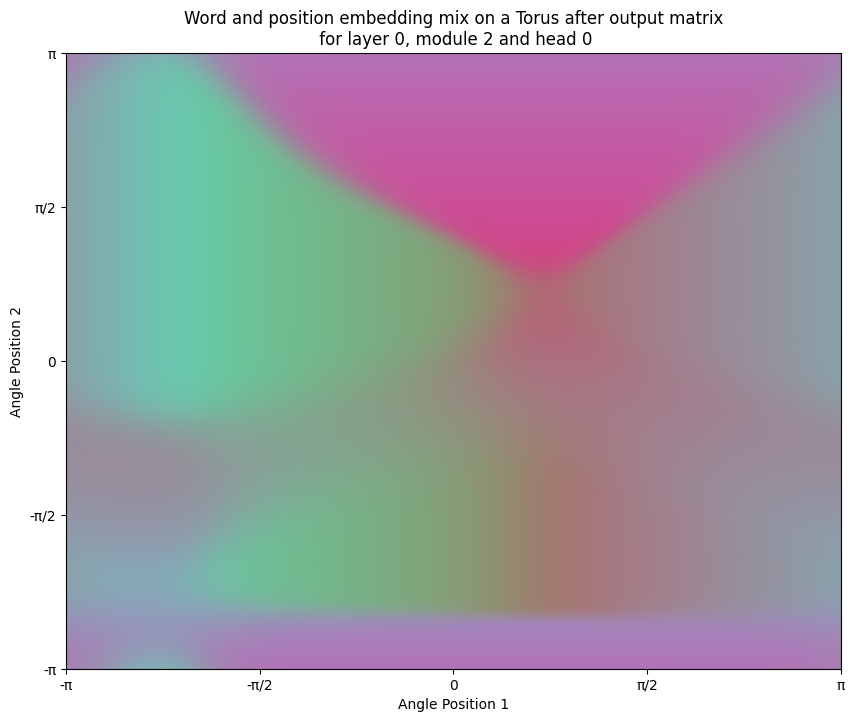

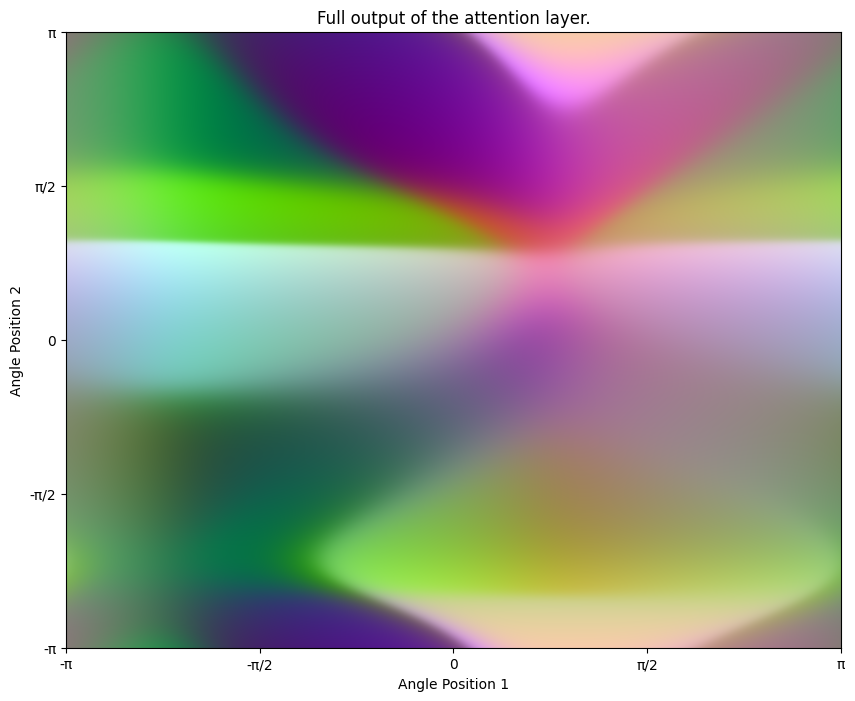

In [8]:
nb_points = 2000
layer = 0

RGB_list = []
RGB_list.append(interp.get_residual_stream(model))
full_RGB = t.zeros((nb_points, nb_points, 3))
for module in range(nb_att_mod):
    for head in range(nb_head):
        RGB_list.append(interp.token_mixing_torus(
            model, 
            module, 
            head, 
            layer, 
            mode="both", 
            hardmax=False, 
            use_OV=True, 
            nb_points=nb_points
        ))
        full_RGB += RGB_list[-1][0]
RGB_list.append(
    (
        full_RGB,
        "Full output of the attention layer."
    )
)

interp.plot_RGB_torus(RGB_list)

One way to make the coloring more salient if to graph the plot in 3d, and have the colors represent the angles of the torus. \
This way on can superpose this deformed torus on the voronoi cells to see the coloring.

In [9]:
interp.mapping_torus(model, normed_shape=True) # The shape is normalized by default for better visualization

## The attention head basis